In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pystac
import rasterio
import rioxarray as rioxr
import stac2dcache
import xarray as xr

from stac2dcache.utils import copy_asset, get_asset

from eratosthenes.postprocessing.solar_tools import make_shading
from eratosthenes.preprocessing.read_s2 import extract_sun_angles_grid_s2
from eratosthenes.processing.matching_tools import lucas_kanade, get_coordinates_of_template_centers
from eratosthenes.generic.mapping_tools import castOrientation
from eratosthenes.generic.filtering_statistical import mad_filtering

# Test co-registration with artificial shade image from DEM

In [2]:
# the dcache API URL is not needed to download/upload data
# DCACHE_API_URL = "https://dcacheview.grid.surfsara.nl:22880/api/v1"
DCACHE_WEBDAV_URL = "https://webdav.grid.surfsara.nl:2880"

In [3]:
dcache_root = (DCACHE_WEBDAV_URL  
    + "/pnfs/grid.sara.nl/data/eratosthenes/disk/")

# path to raster DEM 
tile_id = "5VMG"
dem_url = dcache_root + f"ArcticDEM_tiles_sentinel-2/{tile_id}.tif"

# catalog with shadow-enhanced images
catalog_id = "red-glacier_sentinel-2_shadows"
catalog_url = dcache_root + catalog_id

# bounds
bbox = (494228.19, 6646652.01, 512136.52, 6656488.90)

In [4]:
# configure connection to dCache
dcache = stac2dcache.configure(
    filesystem="dcache", 
    token_filename="macaroon.dat"
)
# dcache.api_url = DCACHE_API_URL

In [5]:
def read_catalog(url):
    """
    Read STAC catalog from URL
    
    :param url: urlpath to the catalog root
    :return: PySTAC Catalog object
    """
    url = url if url.endswith("catalog.json") else f"{url}/catalog.json"
    catalog = pystac.Catalog.from_file(url)
    return catalog

In [6]:
# read image catalog
catalog = read_catalog(catalog_url)

In [7]:
items = catalog.get_all_items()

In [8]:
item = next(items)

In [9]:
link = item.get_links("computed_from").pop()
scene_item = link.resolve_stac_object().target
scene_item

<Item id=S2B_5VMG_20210326_0_L1C>

In [10]:
metadata = get_asset(
    scene_item.get_parent(),
    asset_key="metadata",
    item_id=scene_item.id,
    filesystem=dcache
)

In [11]:
zenith_angle, azimuth_angle = extract_sun_angles_grid_s2(metadata)
zenith_angle.mean(), azimuth_angle.mean()

(57.706363939778676, 170.56537940913006)

In [12]:
# load DEM
f = dcache.open(dem_url, 'rb')
with rasterio.open(f) as ds:
    dem = rioxr.open_rasterio(ds, masked=True)
    dem.load()
    dem = dem.squeeze()
dem

<xarray.DataArray (y: 10980, x: 10980)>
array([[653.60516357, 654.98968506, 656.11724854, ..., 788.64624023,
        796.52758789, 807.58410645],
       [658.20306396, 659.89971924, 661.39373779, ..., 791.93927002,
        802.09204102, 812.38885498],
       [662.65698242, 664.85321045, 666.36627197, ..., 794.63146973,
        806.35559082, 820.25506592],
       ...,
       [ 64.64343262,  64.20005798,  64.18184662, ...,          nan,
                 nan,          nan],
       [ 63.19478607,  64.3474884 ,  64.2657547 , ...,          nan,
                 nan,          nan],
       [ 63.17325211,  63.78247833,  64.82928467, ...,          nan,
                 nan,          nan]])
Coordinates:
    band         int64 1
  * y            (y) float64 6.7e+06 6.7e+06 6.7e+06 ... 6.59e+06 6.59e+06
  * x            (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [13]:
sun_angles = xr.DataArray(
    np.stack([zenith_angle, azimuth_angle]), 
    dims=('orientation', 'y', 'x'), 
    coords={
        'orientation': ['zenith', 'azimuth'],
        'x': dem.x, 
        'y': dem.y
    }
)
sun_angles = sun_angles.rio.set_crs(dem.spatial_ref.crs_wkt)
sun_angles = sun_angles.rio.set_nodata(dem.rio.nodata)

In [14]:
# resize
dem = dem.rio.slice_xy(*bbox).squeeze()
sun_angles = sun_angles.rio.slice_xy(*bbox)

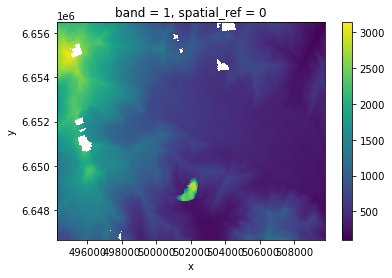

In [15]:
dem.plot.imshow()

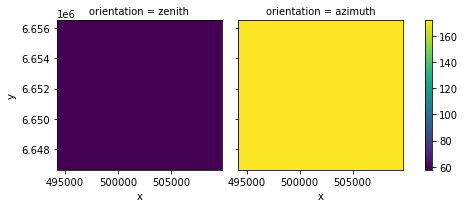

In [16]:
sun_angles.plot.imshow(col='orientation')

In [17]:
shade = make_shading(dem.data, azimuth_angle.mean(), zenith_angle.mean())

In [18]:
shade = xr.DataArray(shade, dims=('y', 'x'), coords={'x': dem.x, 'y': dem.y})
shade = ((shade - shade.min()) / (shade.max() - shade.min()))
shade = shade.rio.set_crs(dem.spatial_ref.crs_wkt)
shade = shade.rio.set_nodata(dem.rio.nodata)

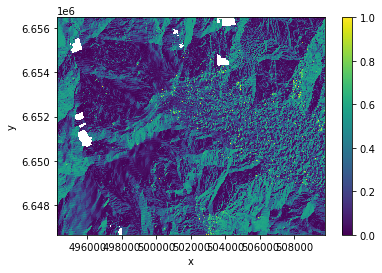

In [19]:
shade.plot.imshow()

In [20]:
shadow = get_asset(
    catalog,
    asset_key="shadow",
    item_id=item.id,
    filesystem=dcache
)

In [21]:
shadow = shadow.squeeze()
shadow

<xarray.DataArray (y: 984, x: 1553)>
array([[0.92313697, 0.92660488, 0.93051822, ..., 0.1001129 , 0.22803161,
        0.20162303],
       [0.92507218, 0.92370764, 0.92255341, ..., 0.10149406, 0.20031211,
        0.29937842],
       [0.92663661, 0.92492   , 0.92344296, ..., 0.0336457 , 0.14565633,
        0.38316249],
       ...,
       [0.05084327, 0.04170608, 0.05859103, ..., 0.92168011, 0.92741353,
        0.93114467],
       [0.0114759 , 0.02086172, 0.04095467, ..., 0.92033969, 0.92637953,
        0.92555229],
       [0.01835552, 0.02616163, 0.04390395, ..., 0.91671379, 0.9245579 ,
        0.92410988]])
Coordinates:
    band         int64 1
  * y            (y) float64 6.656e+06 6.656e+06 ... 6.647e+06 6.647e+06
  * x            (x) float64 4.942e+05 4.942e+05 ... 5.097e+05 5.098e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    nan
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

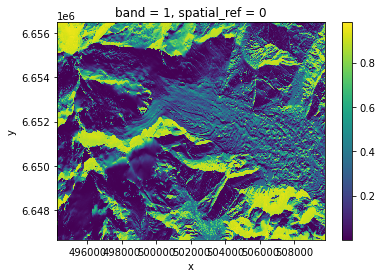

In [22]:
shadow.plot.imshow()

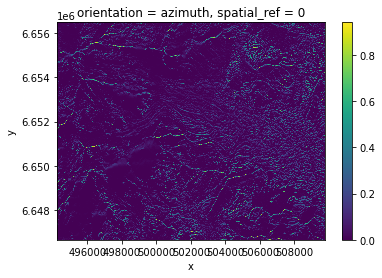

In [23]:
shadow_casted = castOrientation(shadow, sun_angles.sel(orientation='azimuth'))
shadow_casted = shadow_casted.where(shadow_casted > 0, 0)
shadow_casted.plot.imshow()

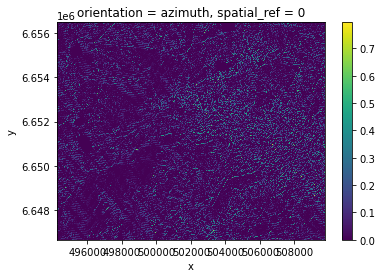

In [24]:
shade_casted = castOrientation(shade, sun_angles.sel(orientation='azimuth'))
shade_casted = shade_casted.where(shade_casted > 0, 0)
shade_casted.plot.imshow()

In [25]:
window_size = 15
sampleI, sampleJ = get_coordinates_of_template_centers(
    shade_casted.data, window_size
)
dx, dy = lucas_kanade(shade_casted.data, shadow_casted.data, window_size, sampleI, sampleJ)

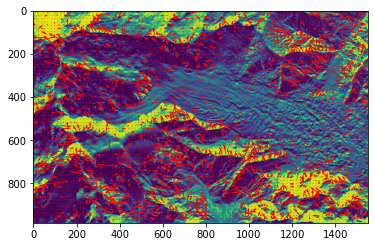

In [46]:
plt.imshow(shadow.data)
plt.quiver(sampleJ, sampleI, dx, dy, color='r', angles='xy', scale_units='xy')

In [27]:
mask = dx != 0
mask.shape, mask.size

((65, 103), 6695)

In [28]:
cut_off = 3
IN = np.logical_and(mad_filtering(dx[mask], cut_off), 
                    mad_filtering(dy[mask], cut_off))
IN.shape

(6653,)

In [29]:
iIN, jIN = np.nonzero(mask)
iIN.shape, jIN.shape

((6653,), (6653,))

In [30]:
dx_ = dx[iIN[IN],jIN[IN]]
dy_ = dy[iIN[IN],jIN[IN]]
dx_.shape, dy_.shape

((4872,), (4872,))

In [31]:
A = np.tile(
        np.identity(2, dtype=float), 
        (len(dx_), 1)
)
y = np.reshape(
        np.hstack((dx_[:, np.newaxis], dy_[:, np.newaxis])),
        (-1, 1)
)

In [32]:
xHat = np.linalg.lstsq(A, y, rcond=None)
xHat[0]

array([[ 0.03888499],
       [-0.0844403 ]])

The least square solution is equivalent to the means of the two displacement arrays:

In [33]:
dx_.mean()

0.03888498714172647

In [34]:
dy_.mean()

-0.0844402977050206

In summary:

In [35]:
mask = dx != 0
dx_ = dx[mask]
dy_ = dy[mask]
cut_off = 3
mask = np.logical_and(
    mad_filtering(dx_, cut_off), 
    mad_filtering(dy_, cut_off)
)
dx_[mask].mean(), dy_[mask].mean()

(0.03888498714172647, -0.0844402977050206)

Function to run coregistration:

In [47]:
def coregister(reference, target, window_size=1, template_grid=True, cut_off_mad_filtering=3):
    """
    Run coregistration of target to reference image
    
    :param reference: 
    :param target: 
    :param window_size: 
    :param template_grid: 
    :param cut_off_mad_filtering: 
    """
    # setup template grid
    temp_grid_spacing = window_size if template_grid else 1
    sampleI, sampleJ = get_coordinates_of_template_centers(
        reference,
        temp_grid_spacing
    )

    # optical flow using Lukas-Kanade
    dx, dy = lucas_kanade(reference, target, window_size, sampleI, sampleJ)
        
    # drop zero displacements
    mask = dx != 0  # what about dy? maybe use ~np.isclose(dx, 0.)?
    dx, dy = dx[mask], dy[mask]

    # MAD filtering
    mask = np.logical_and(mad_filtering(dx, cut_off_mad_filtering),
                          mad_filtering(dy, cut_off_mad_filtering))
    dx, dy = dx[mask], dy[mask]
    
    return dx.mean(), dy.mean()

In [48]:
dx, dy = coregister(shade_casted.data, shadow_casted.data, window_size=15, template_grid=True)
dx, dy

(0.03888498714172647, -0.0844402977050206)